## 생성적 적대 신경망(Generative Adversarial Network )
생성자(가상의 이미지를 만들어내는 공장)
와 판별자를 만들어야함

In [29]:
from tensorflow.keras.layers import Input, Reshape, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist

In [10]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

128로 한건 임의로 상정한 것이고, 이미지의 크기는 7*7 Why? Upsampling2D 함수를 사용하면. 해당 이미지 크기는 두배로 되기때문이고, 위 코드를 보면 Upsampling2D가 두번 사용


In [12]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

## 위 코드는 판별자

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_2 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


11501568/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7017  g_loss:0.6110
epoch:1  d_loss:0.4584  g_loss:0.3118
epoch:2  d_loss:0.4727  g_loss:0.0913
epoch:3  d_loss:0.6023  g_loss:0.0506
epoch:4  d_loss:0.6388  g_loss:0.0967
epoch:5  d_loss:0.5359  g_loss:0.2720
epoch:6  d_loss:0.4914  g_loss:0.5920
epoch:7  d_loss:0.4760  g_loss:0.8568
epoch:8  d_loss:0.4983  g_loss:0.8786
epoch:9  d_loss:0.4889  g_loss:0.8779
epoch:10  d_loss:0.4197  g_loss:0.8011
epoch:11  d_loss:0.4481  g_loss:0.6890
epoch:12  d_loss:0.4011  g_loss:0.8738
epoch:13  d_loss:0.3891  g_loss:0.9936
epoch:14  d_loss:0.5461  g_loss:0.9598
epoch:15  d_loss:0.5681  g_loss:1.1392
epoch:16  d_loss:0.5165  g_loss:0.9288
epoch:17  d_loss:0.4217  g_loss:0.9545
epoch:18  d_loss:0.4534  g_loss:0.8220
epoch:19  d_loss:0.4905  g_loss:0.5483
epoch:20  d_loss:0.4598  g_loss:0.4602
epoch:21  d_loss:0.3606  g_loss:0.7040
epoch:22  d_loss:0.4294  g_loss:0.7481
epoch:23  d_loss:0.4385  g_loss:0.6977
epoch:24 

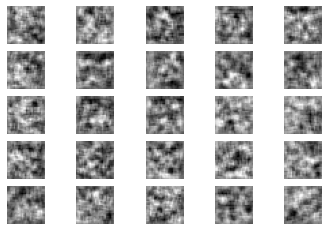

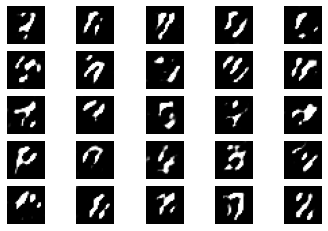

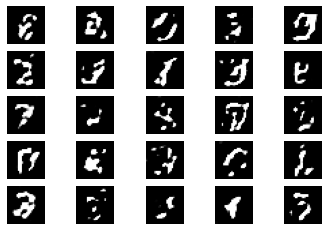

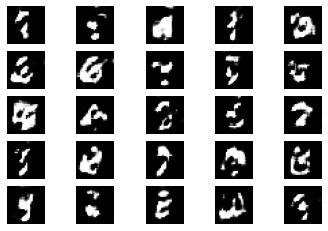

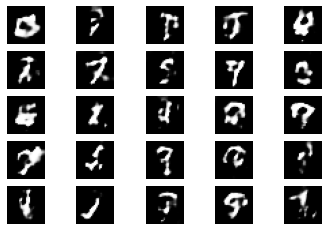

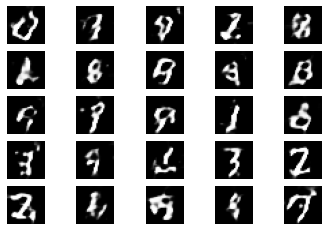

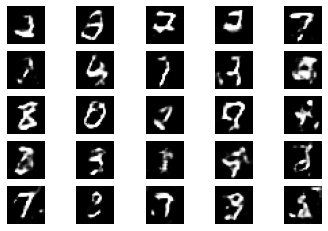

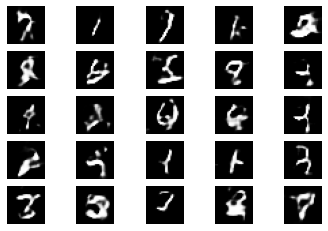

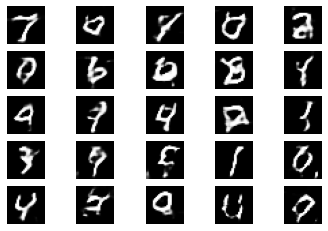

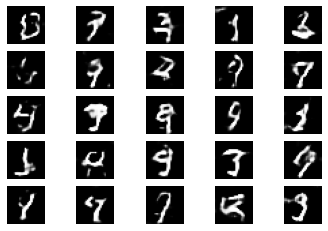

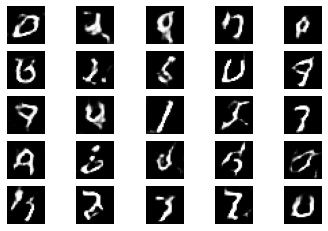

In [27]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.


In [30]:
# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다. 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 5s 7ms/step - loss: 0.2034 - val_loss: 0.1374
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1258 - val_loss: 0.1166
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1141 - val_loss: 0.1090
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1081 - val_loss: 0.1047
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1042 - val_loss: 0.1014
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1012 - val_loss: 0.0985
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0988 - val_loss: 0.0965
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0968 - val_loss: 0.0946
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0952 - val_loss: 0.0933
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0938 - val_loss: 0.0920

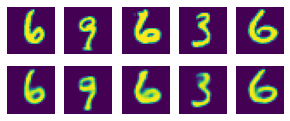

In [31]:
 # 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()